In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics.classification import AUROC
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything

from tqdm.notebook import tqdm  # Progress bar

from sklearn.model_selection import (train_test_split, cross_validate)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)

seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

%matplotlib inline

Seed set to 0


In [2]:
def summary_plot(results, ax, col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss', fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],[training_legend, valid_legend]):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='x',
            color=color,
            ax=ax, alpha=.6,
        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

## Default data

In [3]:
Default = load_data('Default')
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


### Train/test split

In [53]:
ms = MS(Default.columns.drop('default'), intercept=False)
X = ms.fit_transform(Default).to_numpy()
y = Default['default'].to_numpy()
X.shape, y.shape

((10000, 3), (10000,))

In [57]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y.shape

(10000,)

In [58]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=1/3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6666, 3), (3334, 3), (6666,), (3334,))

### Neural network model

In [59]:
class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 2),
        )

    def forward(self, x):
        return self.net(x)

In [60]:
default_model = DefaultModel(X.shape[1])

In [61]:
summary(
    default_model, 
    input_size=X_train.shape, 
    col_names=[
        'input_size', 
        'output_size', 
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666, 2]                 --
├─Sequential: 1-1                        [6666, 3]                 [6666, 2]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 2]                 22
Total params: 62
Trainable params: 62
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.08
Forward/backward pass size (MB): 0.64
Params size (MB): 0.00
Estimated Total Size (MB): 0.72

Convert `numpy.ndarray` data to `torch.tensor`.

In [62]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train)
default_train = TensorDataset(X_train_t, y_train_t)

In [64]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test)
default_test = TensorDataset(X_test_t, y_test_t)

In [65]:
max_num_workers = rec_num_workers()
max_num_workers

8

Data module.

In [66]:
default_dm = SimpleDataModule(
    default_train, 
    default_test,
    batch_size=32,
    num_workers=min(4, max_num_workers),
    validation=default_test
)

CSV logger.

In [67]:
default_logger = CSVLogger('logs', name='default')

Classification module.

In [68]:
default_module = SimpleModule.classification(
    default_model,
    metrics={'auroc': AUROC(task='multiclass', num_classes=2)},
    num_classes=2,
)

In [69]:
default_module

SimpleModule(
  (model): DefaultModel(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (loss): CrossEntropyLoss()
)

NN trainer.

In [70]:
default_trainer = Trainer(
    deterministic=True,
    max_epochs=10,
    log_every_n_steps=10,
    logger=default_logger,
    callbacks=[ErrorTracker()],
    enable_progress_bar=0,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [71]:
default_trainer.fit(default_module, datamodule=default_dm)


  | Name  | Type             | Params
-------------------------------------------
0 | model | DefaultModel     | 62    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
62        Trainable params
0         Non-trainable params
62        Total params
0.000     Total estimated model params size (MB)
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/

In [72]:
default_trainer.test(default_module, datamodule=default_dm)

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.970005989074707
       test_auroc                   0.5
        test_loss           0.13505148887634277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13505148887634277,
  'test_auroc': 0.5,
  'test_accuracy': 0.970005989074707}]

In [73]:
default_results = pd.read_csv(default_logger.experiment.metrics_file_path)

In [74]:
default_results

,epoch,step,test_accuracy,test_auroc,test_loss,train_accuracy_epoch,train_accuracy_step,train_auroc_epoch,train_auroc_step,train_loss,valid_accuracy,valid_auroc,valid_loss
0,0,9,NaN,NaN,NaN,NaN,1.00000,NaN,0.000000,NaN,NaN,NaN,NaN
1,0,19,NaN,NaN,NaN,NaN,0.90625,NaN,0.504167,NaN,NaN,NaN,NaN
2,0,29,NaN,NaN,NaN,NaN,0.96875,NaN,0.290323,NaN,NaN,NaN,NaN
3,0,39,NaN,NaN,NaN,NaN,0.93750,NaN,0.483871,NaN,NaN,NaN,NaN
4,0,49,NaN,NaN,NaN,NaN,0.96875,NaN,0.338710,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,9,2079,NaN,NaN,NaN,NaN,0.96875,NaN,0.500000,NaN,NaN,NaN,NaN
226,9,2089,NaN,NaN,NaN,NaN,1.00000,NaN,0.000000,NaN,NaN,NaN,NaN
227,9,2089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970006,0.5,0.135051
228,9,2089,NaN,NaN,NaN,0.965047,NaN,0.338514,NaN,0.151826,NaN,NaN,NaN


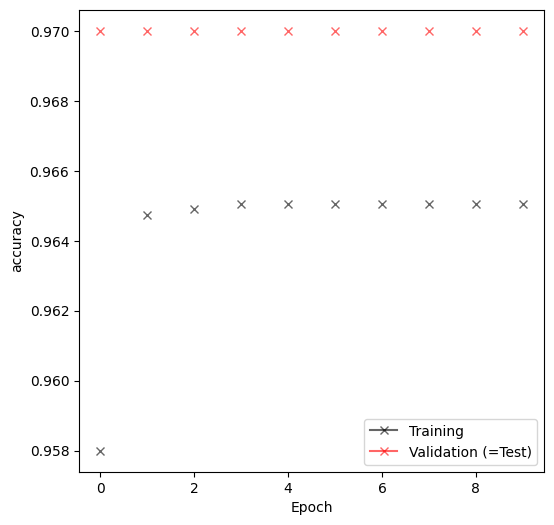

In [75]:
_, ax = plt.subplots(figsize=(6, 6))
ax = summary_plot(
    default_results,
    ax,
    col='accuracy',
    ylabel='accuracy',
    valid_legend='Validation (=Test)',
)

TODO: Somehow, it the plot looks suspicious, figure-out what's wrong and fix it!

### Logistic regression

In [76]:
lr = LogisticRegression(random_state=0)
lr.fit(X, y)

LogisticRegression(random_state=0)

In [77]:
scores = cross_validate(
    lr, X, y, cv=5, 
    scoring='roc_auc', 
    return_train_score=True,
    n_jobs=-1, verbose=1,
)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


{'fit_time': array([0.03086472, 0.02483821, 0.02569389, 0.02428007, 0.0226717 ]),
 'score_time': array([0.00123334, 0.00119495, 0.00120401, 0.00115204, 0.00114822]),
 'test_score': array([0.95244587, 0.95881514, 0.94012092, 0.95998023, 0.93651505]),
 'train_score': array([0.94895508, 0.9471805 , 0.95194445, 0.94693532, 0.95285732])}

In [78]:
scores['train_score'].mean(), scores['test_score'].mean()

(0.9495745332674422, 0.9495754403879175)